In [15]:
from collections import defaultdict
from sklearn.preprocessing import MinMaxScaler
import numpy as np
import pandas as pd
from Bio import SeqIO
import os

# Define directories
fasta_folder = '/Users/danielgeorge/Documents/work/ml/misc/gan/fasta_files'
csv_folder = '/Users/danielgeorge/Documents/work/ml/misc/gan/traces'

# Function to read FASTA file
def read_fasta(file_path):
    with open(file_path, 'r') as file:
        return str(list(SeqIO.parse(file_path, "fasta"))[0].seq)

# Function to read CSV file
def read_csv(file_path):
    return pd.read_csv(file_path).values

# Dictionary to store the sums of chromatogram peaks
nucleotide_sums = defaultdict(lambda: [0, 0, 0, 0])
nucleotide_counts = defaultdict(int)

# Iterate through the CSV files and corresponding FASTA files
for csv_file in os.listdir(csv_folder):
    fasta_file = csv_file.replace('.csv', '.fasta')
    fasta_sequence = read_fasta(os.path.join(fasta_folder, fasta_file))
    csv_sequence = read_csv(os.path.join(csv_folder, csv_file))

    if len(csv_sequence) == 0 or len(fasta_sequence) == 0 or len(csv_sequence) != len(fasta_sequence):
       continue

    # normalize csv_sequence
    scaler = MinMaxScaler()
    csv_sequence = scaler.fit_transform(csv_sequence)

    # Iterate through the sequences and accumulate the sums
    for i, nucleotide in enumerate(fasta_sequence):
        if nucleotide in 'ACGT':
            nucleotide_sums[nucleotide] += csv_sequence[i]
            nucleotide_counts[nucleotide] += 1

# Compute the average chromatogram peaks for each nucleotide
nucleotide_averages = {nucleotide: np.array(sums) / count for nucleotide, (sums, count) in zip(nucleotide_sums.keys(), zip(nucleotide_sums.values(), nucleotide_counts.values()))}

nucleotide_averages

{'C': array([0.01289181, 0.55477766, 0.00837035, 0.01701909]),
 'A': array([0.43197003, 0.02239163, 0.00811062, 0.01246365]),
 'T': array([0.01236317, 0.02159651, 0.01129136, 0.54167074]),
 'G': array([0.01431625, 0.00882186, 0.42467744, 0.01488374])}

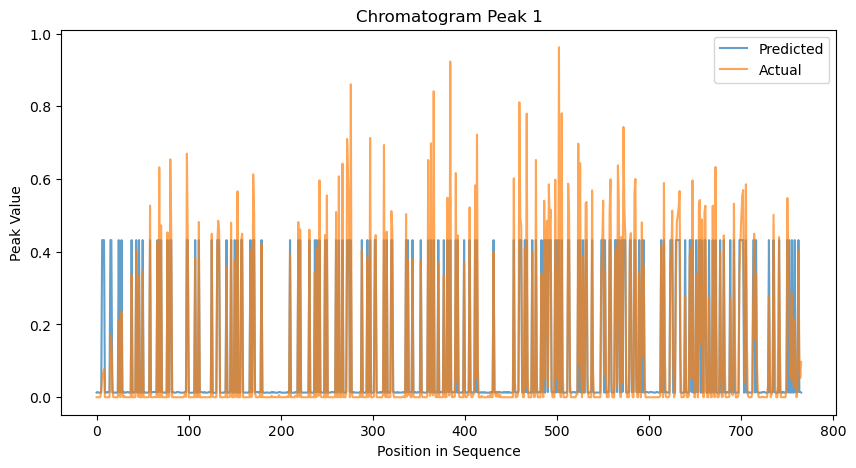

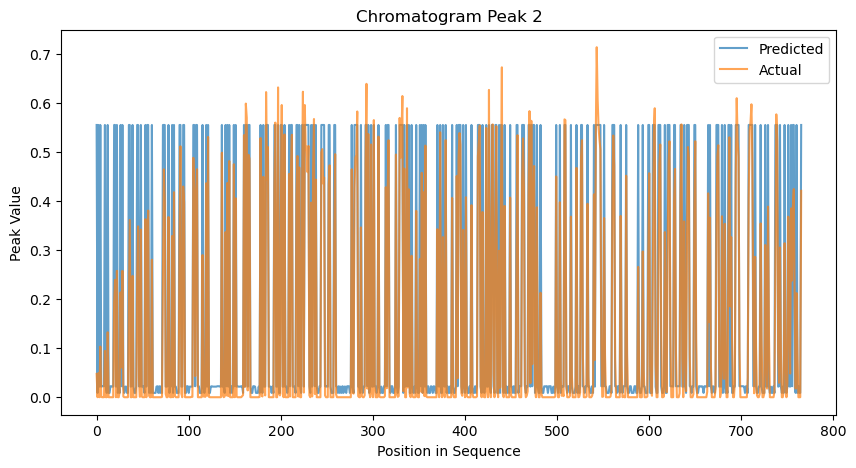

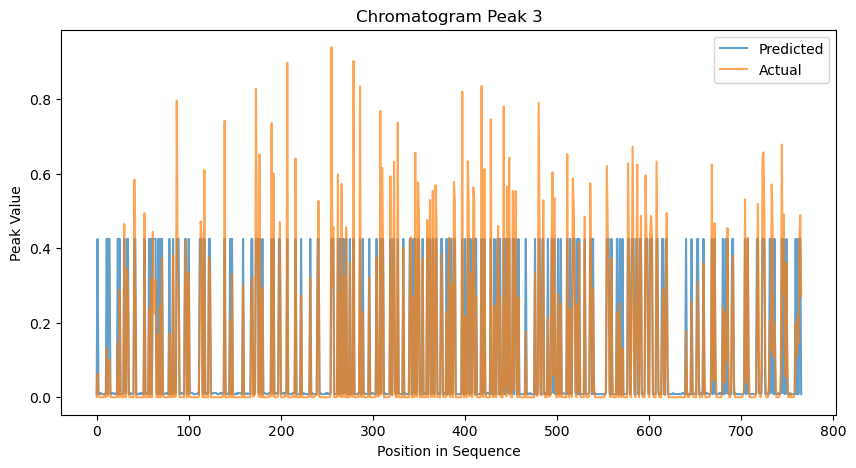

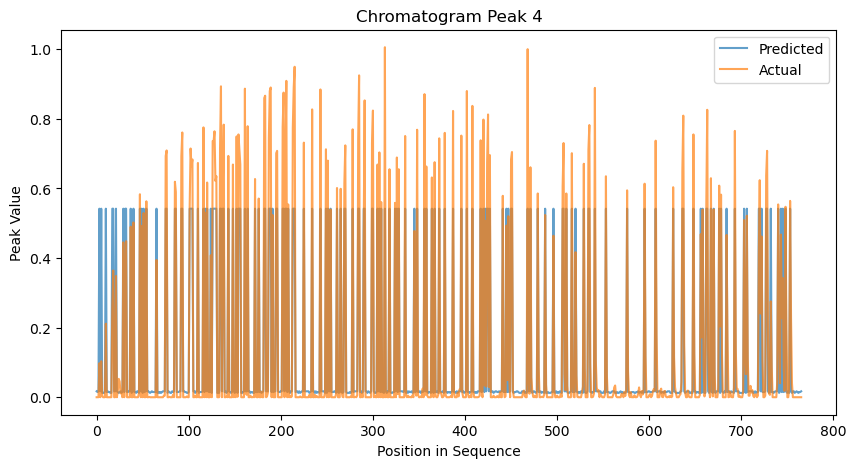

In [16]:
import matplotlib.pyplot as plt

# Paths to test FASTA and CSV files
test_fasta_file = '/Users/danielgeorge/Documents/work/ml/misc/gan/test_case/X09140N00.fasta'
test_csv_file = '/Users/danielgeorge/Documents/work/ml/misc/gan/test_case/X09140N00.csv'

# Read test FASTA and CSV files
test_fasta_sequence = read_fasta(test_fasta_file)
test_csv_sequence = read_csv(test_csv_file)

# normalize the test CSV sequence
test_csv_sequence = scaler.transform(test_csv_sequence)

# Lists to store predictions and actual values
predictions = []
actual_values = []

# Apply naive baseline: map each nucleotide to its corresponding average chromatogram peaks
for i, nucleotide in enumerate(test_fasta_sequence):
    if nucleotide in nucleotide_averages and i < len(test_csv_sequence):
        predictions.append(nucleotide_averages[nucleotide])
        actual_values.append(test_csv_sequence[i])

# Convert to NumPy arrays for easier handling
predictions = np.array(predictions)
actual_values = np.array(actual_values)

# Plot the results for each chromatogram peak
for i in range(4):
    plt.figure(figsize=(10, 5))
    plt.plot(predictions[:, i], label='Predicted', alpha=0.7)
    plt.plot(actual_values[:, i], label='Actual', alpha=0.7)
    plt.title(f'Chromatogram Peak {i + 1}')
    plt.xlabel('Position in Sequence')
    plt.ylabel('Peak Value')
    plt.legend()
    plt.show()

In [17]:
from sklearn.metrics import mean_squared_error

# Calculate the Mean Squared Error (MSE) for each chromatogram peak
mse_values = [mean_squared_error(actual_values[:, i], predictions[:, i]) for i in range(4)]

# Return the MSE for each peak
mse_values

[0.006082335753100384,
 0.00888088417151475,
 0.009139759583797471,
 0.008746691089663906]

/Users/danielgeorge/miniforge3/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:972: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


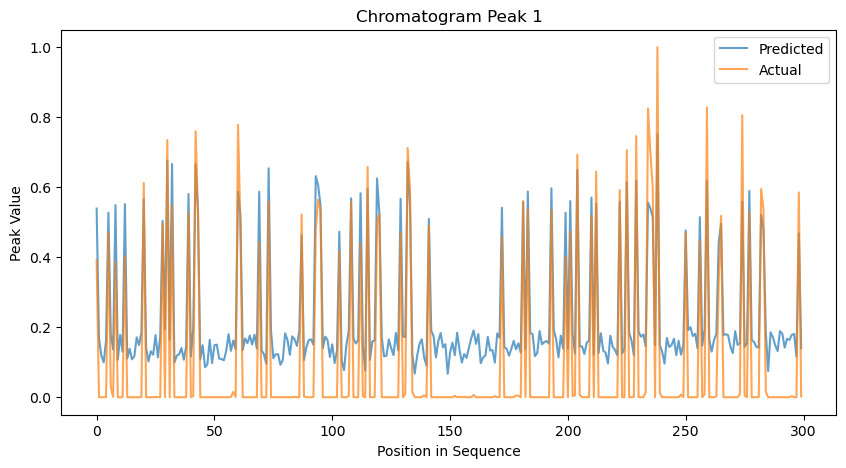

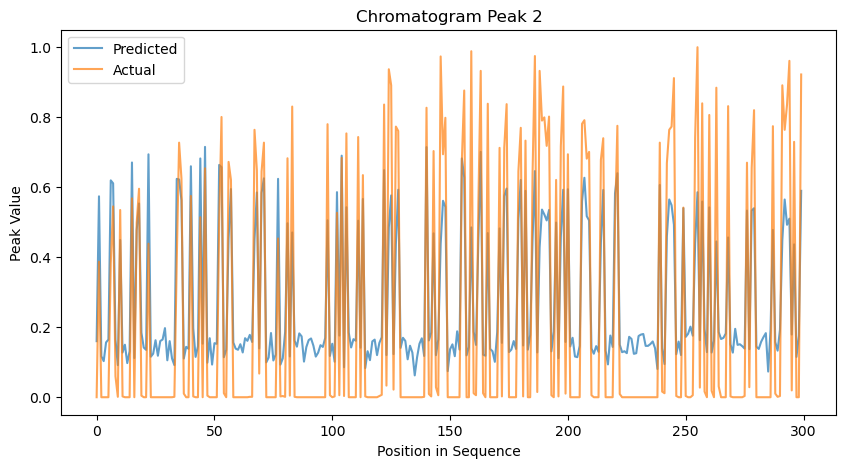

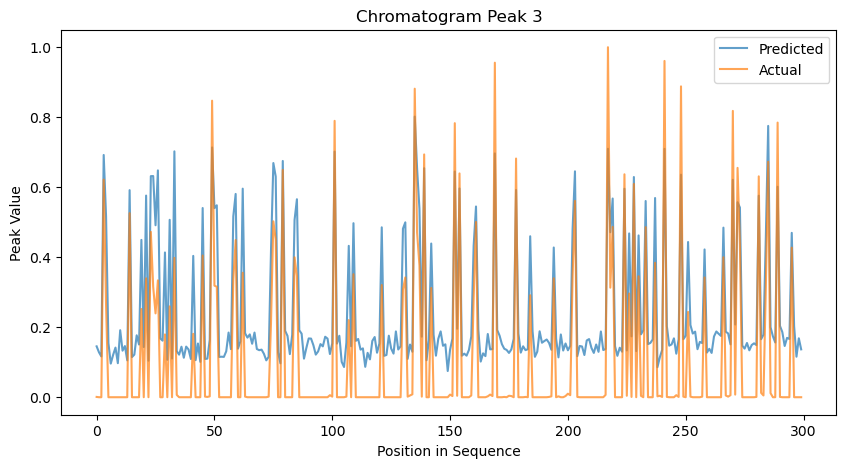

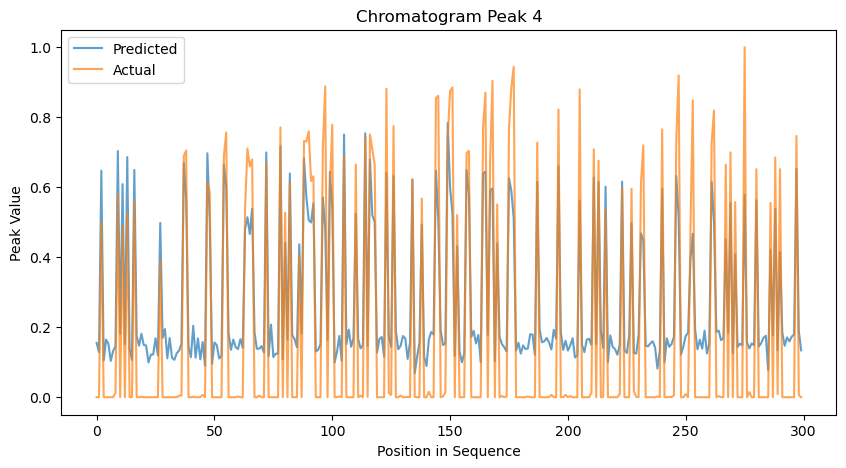

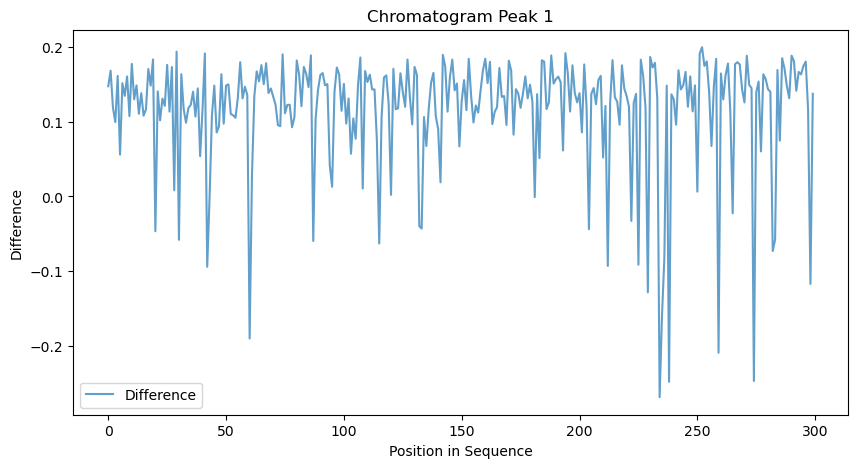

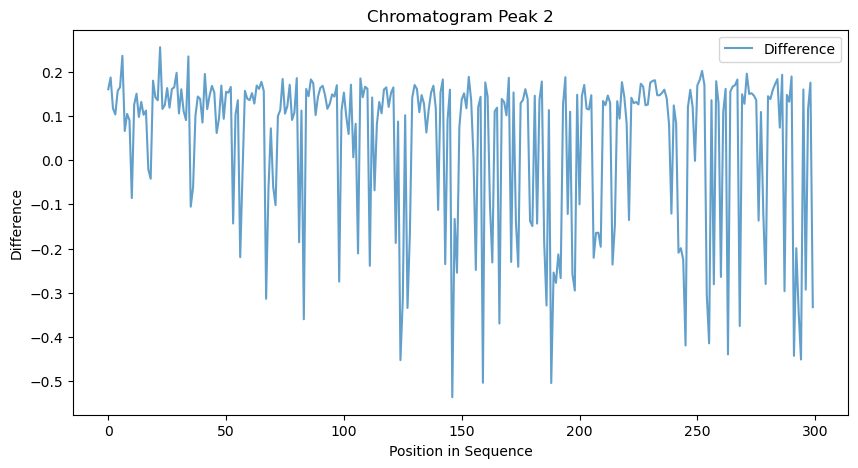

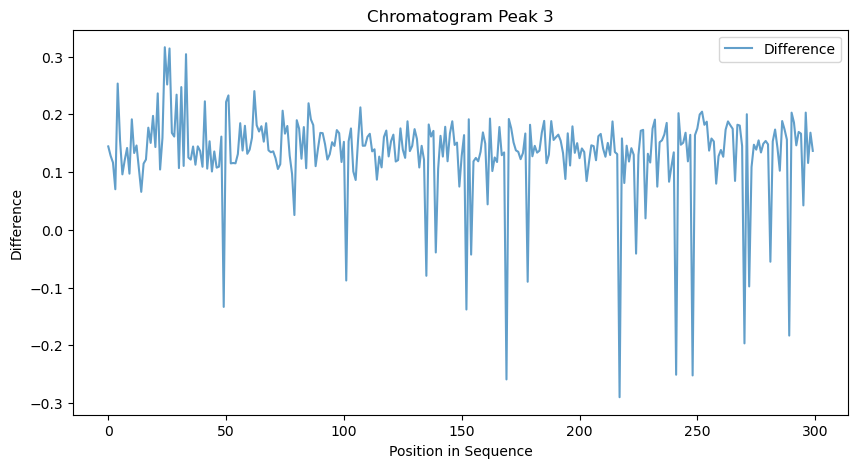

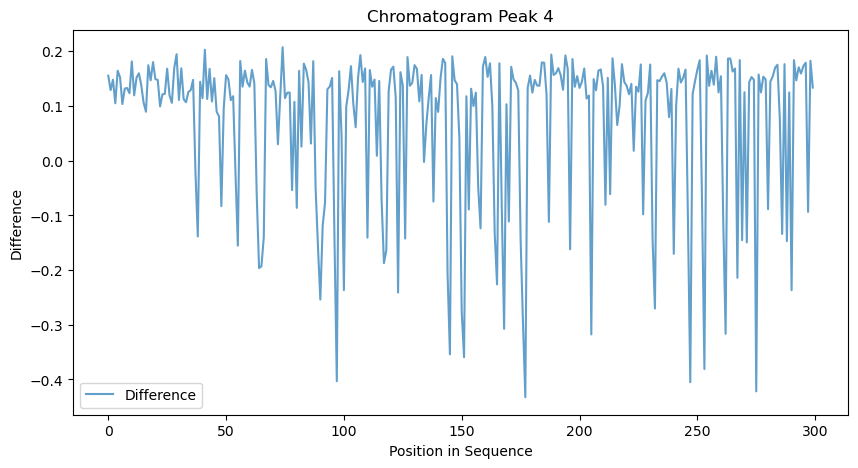

In [6]:
import torch
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.optim as optim
import os
import pandas as pd
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import OneHotEncoder
import numpy as np
from Bio import SeqIO
from sklearn.preprocessing import MinMaxScaler

fasta_folder = '/Users/danielgeorge/Documents/work/ml/misc/gan/fasta_files'
csv_folder = '/Users/danielgeorge/Documents/work/ml/misc/gan/traces'

# Paths to test FASTA and CSV files
test_fasta_file = '/Users/danielgeorge/Documents/work/ml/misc/gan/test_case/X09140N00.fasta'
test_csv_file = '/Users/danielgeorge/Documents/work/ml/misc/gan/test_case/X09140N00.csv'

# Function to read FASTA file
def read_fasta(file_path):
    with open(file_path, 'r') as file:
        return str(list(SeqIO.parse(file_path, "fasta"))[0].seq)

# Function to read CSV file
def read_csv(file_path):
    return pd.read_csv(file_path).values

# Read test FASTA and CSV files
test_fasta_sequence = read_fasta(test_fasta_file)
test_csv_sequence = read_csv(test_csv_file)

# Hyperparameters
input_size = 5  # A, C, G, T, N
hidden_size = 64
seq_length = 300
start_base = 40
learning_rate = 1e-3
epochs = 10
batch_size = 64  # Adjust this depending on your GPU memory

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

class SangerSequencingDataset(Dataset):
    def __init__(self, fasta_folder, csv_folder):
        csv_files = [file for file in os.listdir(csv_folder)]
        csv_files = [file for file in csv_files if len(pd.read_csv(os.path.join(csv_folder, file)).values[start_base:start_base + seq_length]) == 300] # Don't include empty CSV files
        fasta_files = [file.replace('.csv', '.fasta') for file in csv_files]

        self.fasta_files = [os.path.join(fasta_folder, file) for file in fasta_files]
        self.csv_files = [os.path.join(csv_folder, file) for file in csv_files]

        self.encoder = OneHotEncoder(sparse=False, categories=[['A', 'C', 'G', 'T', 'N']])

    def __len__(self):
        return len(self.fasta_files)

    def __getitem__(self, idx):
        # Read FASTA file
        fasta_sequence = str(list(SeqIO.parse(self.fasta_files[idx], "fasta"))[0].seq)

        # Convert FASTA sequence to one-hot encoding
        fasta_sequence = self.encoder.fit_transform(np.array(list(fasta_sequence)[start_base:start_base + seq_length]).reshape(-1, 1))

        # Read CSV file
        csv_sequence = pd.read_csv(self.csv_files[idx]).values[start_base:start_base + seq_length]

        return torch.tensor(fasta_sequence, dtype=torch.float32), torch.tensor(csv_sequence, dtype=torch.float32)

# Model architecture
class SequenceToSangerModel(nn.Module):
    def __init__(self, input_size, hidden_size, seq_length):
        super(SequenceToSangerModel, self).__init__()
        self.conv1 = nn.Conv1d(input_size, hidden_size, kernel_size=3, padding=1)
        self.lstm = nn.LSTM(hidden_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, 4)  # 4 outputs for A, C, G, T

    def forward(self, x):
        x = self.conv1(x).transpose(-1, -2)
        x, _ = self.lstm(x)
        x = self.fc(x)
        return nn.functional.softmax(x, dim=-1)

# Create dataset and dataloader with updated class
dataset = SangerSequencingDataset(fasta_folder, csv_folder)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)  

# Path to the model to be loaded
model_path = f'/Users/danielgeorge/Documents/work/ml/misc/gan/model_epoch_4.pth'

# Load model
model = SequenceToSangerModel(input_size, hidden_size, seq_length).to(device)
model.load_state_dict(torch.load(model_path, map_location=device))  # map_location ensures the model is loaded on CPU
model.eval()  # Set to evaluation mode

# Read test FASTA and CSV files
test_fasta_sequence = str(list(SeqIO.parse(test_fasta_file, "fasta"))[0].seq)
test_fasta_sequence = dataset.encoder.fit_transform(np.array(list(test_fasta_sequence)[start_base:start_base + seq_length]).reshape(-1, 1))
test_csv_sequence = pd.read_csv(test_csv_file).values[start_base:start_base + seq_length]

# Normalize csv
scaler = MinMaxScaler()
test_csv_sequence = scaler.fit_transform(test_csv_sequence)

# Convert to torch tensors
test_fasta_tensor = torch.tensor(test_fasta_sequence, dtype=torch.float32).unsqueeze(0).transpose(2, 1).to(device)
test_csv_tensor = torch.tensor(test_csv_sequence, dtype=torch.float32).unsqueeze(0).to(device)

# Get predictions
with torch.no_grad():
    predictions = model(test_fasta_tensor)

# Rescale the predictions if necessary (e.g., if MinMaxScaler was applied during training)
# Convert predictions back to CPU and NumPy
predictions = predictions.squeeze().cpu().numpy()

# Make the predictions that don't match the input sequence 0
# The model is given a nucleotide sequence and asked to predict the chromatogram peaks for that sequence
# Only keep the predictions that match the input sequence and make the other probabilities 0
# for i in range(predictions.shape[0]):
#     predictions[i] *= test_fasta_sequence[i,:4]

# Plot the results for each chromatogram peak
for i in range(4):
    plt.figure(figsize=(10, 5))
    plt.plot(predictions[:, i], label='Predicted', alpha=0.7)
    plt.plot(test_csv_sequence[:, i], label='Actual', alpha=0.7)
    plt.title(f'Chromatogram Peak {i + 1}')
    plt.xlabel('Position in Sequence')
    plt.ylabel('Peak Value')
    plt.legend()
    plt.show()


# plot the difference between the predicted and actual chromatogram peaks
for i in range(4):
    plt.figure(figsize=(10, 5))
    plt.plot(predictions[:, i] - test_csv_sequence[:, i], label='Difference', alpha=0.7)
    plt.title(f'Chromatogram Peak {i + 1}')
    plt.xlabel('Position in Sequence')
    plt.ylabel('Difference')
    plt.legend()
    plt.show()

In [5]:
from sklearn.metrics import mean_squared_error

# Calculate the Mean Squared Error (MSE) for each chromatogram peak
mse_values = [mean_squared_error(test_csv_sequence[:, i], predictions[:, i]) for i in range(4)]

# Return the MSE for each peak
mse_values
# baseline
# [0.006082335753100384,
#  0.00888088417151475,
#  0.009139759583797471,
#  0.008746691089663906]
# raw model
# [0.01982550848781812,
#  0.03278213877426804,
#  0.023858744322548232,
#  0.025410910543855057]
# hard coded model
# [0.002167258807984383,
#  0.018735516304010734,
#  0.006857639404487346,
#  0.00926268533471743]

[0.002167258807984383,
 0.018735516304010734,
 0.006857639404487346,
 0.00926268533471743]